# Google Drive Mount

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# Imports

In [8]:
!pip install craft-text-detector

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.3 MB 1.2 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.6.0.66
    Uninstalling opencv-python-4.6.0.66:
      Successfully uninstalled opencv-python-4.6.0.66


In [9]:
from google.colab.patches import cv2_imshow
import imutils
import cv2
from craft_text_detector import read_image, load_craftnet_model, load_refinenet_model, get_prediction, export_detected_regions
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Input, Conv2D
from tensorflow.keras.optimizers import Adam
from PIL import Image

# Training

## Data

In [ ]:
train_path = 'gdrive/MyDrive/Pengcit/license/data/train'
val_path = 'gdrive/MyDrive/Pengcit/license/data/val'

datagen = ImageDataGenerator(
    rescale = 1./255,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_datagen = datagen.flow_from_directory(
    train_path,
    target_size = (32,32),
    batch_size = 1
)

val_datagen = datagen.flow_from_directory(
    val_path,
    target_size = (32,32),
    batch_size = 1
)

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


## Model

In [ ]:
def FineTunedCNN(learning_rate):
  base_model = VGG19(include_top=False, input_tensor=Input(shape = (32,32,3)))

  model = Sequential()
  for layer in base_model.layers:
    model.add(layer)
  
  model.add(Flatten())
  model.add(Dense(128, activation="relu"))
  model.add(Dense(36, activation="softmax"))

  loss = "categorical_crossentropy"
  optimizer = Adam(learning_rate=learning_rate)
  metrics = ["accuracy"]
  model.compile(
      loss = loss,
      optimizer = optimizer,
      metrics = metrics
  )

  return model

## Train

In [ ]:
def train(learning_rate, epochs):
  model = FineTunedCNN(learning_rate)
  model.fit(
      train_datagen,
      steps_per_epoch = train_datagen.n,
      validation_data = val_datagen,
      validation_steps = val_datagen.n,
      epochs = epochs
  )
  return model

In [ ]:
physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [ ]:
model_a = train(2e-5, 30)

80134624/80134624 [==============================] - 3s 0us/step
Epoch 1/30
864/864 [==============================] - 559s 637ms/step - loss: 1.6926 - accuracy: 0.5208 - val_loss: 0.4291 - val_accuracy: 0.8796
Epoch 2/30
864/864 [==============================] - 20s 23ms/step - loss: 0.3987 - accuracy: 0.8727 - val_loss: 0.3260 - val_accuracy: 0.8935
Epoch 3/30
864/864 [==============================] - 20s 23ms/step - loss: 0.2286 - accuracy: 0.9259 - val_loss: 0.2464 - val_accuracy: 0.9213
Epoch 4/30
864/864 [==============================] - 20s 23ms/step - loss: 0.1232 - accuracy: 0.9595 - val_loss: 0.1613 - val_accuracy: 0.9537
Epoch 5/30
864/864 [==============================] - 21s 24ms/step - loss: 0.2696 - accuracy: 0.9213 - val_loss: 0.3982 - val_accuracy: 0.9028
Epoch 6/30
864/864 [==============================] - 20s 23ms/step - loss: 0.1626 - accuracy: 0.9502 - val_loss: 0.0711 - val_accuracy: 0.9676
Epoch 7/30
864/864 [==============================] - 20s 23ms/step -

## Export

In [ ]:
save_path = 'gdrive/MyDrive/Pengcit/license/data/model_2_100.h5'
model_a.save(save_path)

# Testing

## ROI

In [1]:
def roi_extract(img):
  # CRAFT
  output_dir = 'gdrive/MyDrive/Pengcit/license/data/craft_output/'

  # read image
  image = read_image(img)

  # load models
  refine_net = load_refinenet_model(cuda=False)
  craft_net = load_craftnet_model(cuda=False)

  # perform prediction
  prediction_result = get_prediction(
      image=image,
      craft_net=craft_net,
      refine_net=refine_net,
      text_threshold=0.7,
      link_threshold=0.4,
      low_text=0.4,
      cuda=False,
      long_size=1280
  )

  # export detected text regions
  exported_file_paths = export_detected_regions(
      image=image,
      regions=prediction_result["boxes"],
      output_dir=output_dir,
      rectify=True
  )

  return exported_file_paths

## Character Segmentation

In [5]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [6]:
def segment_characters(roi) :
    # Preprocess cropped license plate roi
    img_lp = cv2.resize(roi, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Invert the image if most are black
    avg_color_per_row = np.average(img_binary_lp, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)
    if (avg_color <= 127) :
      img_binary_lp = cv2.bitwise_not(img_binary_lp)

    img_binary_lp = cv2.erode(img_binary_lp, (4,4))
    img_binary_lp = cv2.dilate(img_binary_lp, (4,4))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

## Model Predict

In [10]:
load_path = 'gdrive/MyDrive/Pengcit/license/data/model.h5'
model_load = tf.keras.models.load_model(load_path)

In [11]:
def fix_dimension(img): 
  new_img = np.zeros((32,32,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img

In [12]:
def predict_plate(char_imgs):
  dic = {}
  characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
  for i,c in enumerate(characters):
      dic[i] = c

  output = []
  for i,ch in enumerate(char_imgs):
      img_ = cv2.resize(ch, (32,32), interpolation=cv2.INTER_AREA)
      img = fix_dimension(img_)
      img = img.reshape(1,32,32,3)
      y_ = model_load.predict(img)[0] 
      y_ = np.argmax(y_)
      character = dic[y_] 
      output.append(character)
      
  plate_number = ''.join(output)
  
  return plate_number

In [13]:
img_path = 'gdrive/MyDrive/Pengcit/license/data/car_2.jpg'
result_paths = roi_extract(img_path)
for path in result_paths:
  img = cv2.imread(path)
  cv2_imshow(img)

Craft text refiner weight will be downloaded to /root/.craft_text_detector/weights/craft_refiner_CTW1500.pth


Downloading...
From: https://drive.google.com/uc?id=1xcE9qpJXp4ofINwXWVhhQIh9S8Z7cuGj
To: /root/.craft_text_detector/weights/craft_refiner_CTW1500.pth
100%|██████████| 1.85M/1.85M [00:00<00:00, 177MB/s]
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Craft text detector weight will be downloaded to /root/.craft_text_detector/weights/craft_mlt_25k.pth


Downloading...
From: https://drive.google.com/uc?id=1bupFXqT-VU6Jjeul13XP7yx2Sg5IHr4J
To: /root/.craft_text_detector/weights/craft_mlt_25k.pth
100%|██████████| 83.2M/83.2M [00:00<00:00, 153MB/s]
/usr/local/lib/python3.8/dist-packages/craft_text_detector/craft_utils.py:415: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  polys = np.array(polys)
/usr/local/lib/python3.8/dist-packages/craft_text_detector/predict.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  polys_as_ratio = np.array(polys_as_ratio)


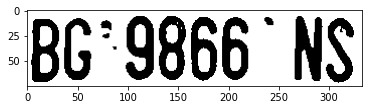

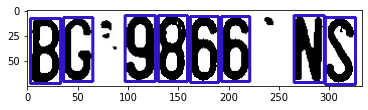

1/1 [==============================] - 0s 15ms/step
B69866NS


In [14]:
roi = cv2.imread(result_paths[0])
char_imgs = segment_characters(roi)

# Predicting the output
result = predict_plate(char_imgs)
print(result)

# References

* Tan, Mingxing, Quoc V.Le. 2021. EfficientNetV2: Smaller Models and Faster Training. http://arxiv.org/abs/2104.00298
* Vajapayee, Sharthak. 2020. License plate recognition using CNN. https://www.kaggle.com/code/sarthakvajpayee/license-plate-recognition-using-cnn
* https://pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/
* https://www.kaggle.com/code/aamnafea/vgg19-fine-tuning